In [2]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
from scipy.stats import norm
from haversine import haversine
from sklearn.preprocessing import MinMaxScaler

In [2]:
city_list=["광주", "울산", "전주", "창원"]
i=2
fire_incident_df=pd.read_csv(city_list[i]+" data 경도 위도 매핑/"+city_list[i]+" 화재 정보.csv")
accident_df=pd.read_csv(city_list[i]+" data 경도 위도 매핑/"+city_list[i]+"_교통사고_통계.csv")
school_df=pd.read_csv(city_list[i]+" data 경도 위도 매핑/"+city_list[i]+" 초중고.csv")
bus_station_df=pd.read_csv(city_list[i]+" data 경도 위도 매핑/"+city_list[i]+"시_버스 정류장.csv")
gas_station_df=pd.read_csv(city_list[i]+" data 경도 위도 매핑/"+city_list[i]+"_충전소_주유소.csv")
weight_df=pd.DataFrame([[0]*7]*len(gas_station_df), columns=['주유소명', '버정거리총합', '상호개수', '교통사고건수','보호구역개수','화재발생건수','총 가중치'])
weight_df['주유소명']=gas_station_df['상호'][:]
## 추가추가

In [3]:
fire_incident_df.head(3)

,조사서번호,시도,시군구,읍면동,주소,위도,경도
0,'170101093018530,전라북도,전주시덕진구,호성동2가,전라북도 전주시덕진구 호성동2가,35.876378,127.146907
1,'170101100618186,전라북도,전주시덕진구,송천동2가,전라북도 전주시덕진구 송천동2가,35.876378,127.146907
2,'170101135933896,전라북도,전주시완산구,평화동2가,전라북도 전주시완산구 평화동2가,35.876378,127.146907


In [4]:
accident_df.head(3)

,Unnamed: 0,시군구,도로명,주소,사고건수,사망자수,중상자수,경상자수,부상신고자수,위도,경도
0,0,전주시,백제대로,전주시 백제대로,63,1,23,94,0,35.842997,127.139671
1,1,전주시,기린대로,전주시 기린대로,15,1,3,14,0,35.847457,127.112191
2,2,전주시,기린대로,전주시 기린대로,87,1,23,102,1,35.847457,127.112191


In [5]:
bus_station_df.head(3)

,설치 지점명,지역(구),지역(동),세부주소,행정동,위도,경도
0,우아롯데아파트,덕진구,우아동,우아동 2동 887,우아2동,35.832510,127.167824
1,여의동우체국전북은행,덕진구,여의동,여의동2가 696,여의동,35.871416,127.076584
2,기린대로경제통상진흥원,덕진구,팔복동,팔복동2가 550,팔복동,35.859761,127.092527


In [6]:
gas_station_df.head(3)

,지역,상호,타입,주소,위도,경도
0,전라북도,직영충전소,충전소,전북 전주시 덕진구 혁신로 360번지,35.864542,127.069401
1,전라북도,(유)삼영에너지,충전소,전북 전주시 완산구 쑥고개로 11 (용복동),35.790810,127.068859
2,전라북도,(유)푸른기업충전소,충전소,전북 전주시 완산구 모악로 4483 (석구동),35.786460,127.128841


## 가산

가능 : 타 주유소, 교통량(교통 사고), 버스 정류장

working on : 차고지 위치

In [7]:
# 거리 총합 리스트
def 거리총합리스트(data1, data2, name_col):
    # distance_list=[]

    for i in range(len(data1)):
        total=0
        for j in range(len(data2)):
            total+=haversine((data1.loc[i]['위도'],data1.loc[i]['경도']),(data2.loc[j]['위도'],data2.loc[j]['경도']), unit = 'km')
        # distance_list.append((data1.loc[i][name_col],total))
        weight_df['버정거리총합'][i]=total
    

In [8]:
# p 반경 이내 개수 리스트(타 주유소)
def 반경이내_개수_리스트(p, data1, data2, name_col):
    count_list=[]
    for i in range(len(data1)):
        count=0
        for j in range(len(data2)):
            dist=haversine((data1.loc[i]['위도'],data1.loc[i]['경도']),(data2.loc[j]['위도'],data2.loc[j]['경도']), unit = 'km')
            if dist<=p:
                # 교통사고 데이터 사고 건수로 count!
                if ('사고건수' in data2.columns):
                    count+=data2.loc[j,'사고건수']
                else:
                    count+=1
        #count_list.append((data1.loc[i][name_col],count-1)) 상호명 매핑 화긴~
        if (count == 0):
            count_list.append(count)
        else:
            count_list.append(count-1)# 자기 자신 제외

    return count_list
   

In [9]:
""" 이건 km
거리총합리스트(gas_station_df, bus_station_df, '상호')
weight_df['버정거리총합']=max(weight_df['버정거리총합'])-weight_df['버정거리총합']
weight_df
""" # 이건 개수
버정거리총합 = 반경이내_개수_리스트(2, gas_station_df, bus_station_df,'상호')
weight_df['버정거리총합']=버정거리총합
weight_df

,주유소명,버정거리총합,상호개수,교통사고건수,보호구역개수,화재발생건수,총 가중치
0,직영충전소,27,0,0,0,0,0
1,(유)삼영에너지,2,0,0,0,0,0
2,(유)푸른기업충전소,59,0,0,0,0,0
3,㈜진성에너지 색장충전소,3,0,0,0,0,0
4,전주유성LPG충전소,4,0,0,0,0,0
...,...,...,...,...,...,...,...
193,(주)안국에너지 호반주유소,79,0,0,0,0,0
194,동아주유소,76,0,0,0,0,0
195,중앙주유소,14,0,0,0,0,0
196,덕산주유소,3,0,0,0,0,0


In [10]:
상호개수 = 반경이내_개수_리스트(2, gas_station_df, gas_station_df,'상호')
weight_df['상호개수']=상호개수
weight_df

,주유소명,버정거리총합,상호개수,교통사고건수,보호구역개수,화재발생건수,총 가중치
0,직영충전소,27,29,0,0,0,0
1,(유)삼영에너지,2,3,0,0,0,0
2,(유)푸른기업충전소,59,19,0,0,0,0
3,㈜진성에너지 색장충전소,3,7,0,0,0,0
4,전주유성LPG충전소,4,9,0,0,0,0
...,...,...,...,...,...,...,...
193,(주)안국에너지 호반주유소,79,20,0,0,0,0
194,동아주유소,76,16,0,0,0,0
195,중앙주유소,14,13,0,0,0,0
196,덕산주유소,3,7,0,0,0,0


In [11]:
교통사고건수=반경이내_개수_리스트(2, gas_station_df, accident_df,'상호')
weight_df['교통사고건수']=교통사고건수
weight_df

,주유소명,버정거리총합,상호개수,교통사고건수,보호구역개수,화재발생건수,총 가중치
0,직영충전소,27,29,62,0,0,0
1,(유)삼영에너지,2,3,2,0,0,0
2,(유)푸른기업충전소,59,19,185,0,0,0
3,㈜진성에너지 색장충전소,3,7,12,0,0,0
4,전주유성LPG충전소,4,9,12,0,0,0
...,...,...,...,...,...,...,...
193,(주)안국에너지 호반주유소,79,20,423,0,0,0
194,동아주유소,76,16,228,0,0,0
195,중앙주유소,14,13,26,0,0,0
196,덕산주유소,3,7,12,0,0,0


## 감점

가능 : 어린이집, 유초중고(2km)

working on : 화재

In [12]:
fire_incident_df.head(3)

,조사서번호,시도,시군구,읍면동,주소,위도,경도
0,'170101093018530,전라북도,전주시덕진구,호성동2가,전라북도 전주시덕진구 호성동2가,35.876378,127.146907
1,'170101100618186,전라북도,전주시덕진구,송천동2가,전라북도 전주시덕진구 송천동2가,35.876378,127.146907
2,'170101135933896,전라북도,전주시완산구,평화동2가,전라북도 전주시완산구 평화동2가,35.876378,127.146907


In [13]:
gas_station_df.head(3)

,지역,상호,타입,주소,위도,경도
0,전라북도,직영충전소,충전소,전북 전주시 덕진구 혁신로 360번지,35.864542,127.069401
1,전라북도,(유)삼영에너지,충전소,전북 전주시 완산구 쑥고개로 11 (용복동),35.790810,127.068859
2,전라북도,(유)푸른기업충전소,충전소,전북 전주시 완산구 모악로 4483 (석구동),35.786460,127.128841


In [14]:
school_df.head(3)

,시도,행정구,교육\n(지원)청,학교급,고등학교\n유형,KEDI 학제,학교명,우편번호,주소,위도,경도
0,전북,전주시,전북,고등학교,일반고,일반고등학교,전북대학교사범대학부설고등학교,54896,전라북도 전주시 덕진구 백제대로 567(금암동. 전북대학교),35.846732,127.129367
1,전북,전주시,전북,고등학교,일반고,일반고등학교,전라고등학교,54836,전라북도 전주시 덕진구 솔내7길 25(송천동1가. 전라고등학교),35.859966,127.124891
2,전북,전주시,전북,고등학교,일반고,일반고등학교,전주고등학교,55007,전라북도 전주시 완산구 권삼득로 2(중노송동. 전주고등학교),35.825388,127.151833


In [15]:
#kinder_df.head(3)

In [16]:
#유치원,,
#보호구역개수=반경이내_개수_리스트(2, gas_station_df, kinder_df, '상호')
#weight_df['보호구역개수']=보호구역개수

In [17]:
보호구역개수=반경이내_개수_리스트(2, gas_station_df, school_df, '상호')
weight_df['보호구역개수']=보호구역개수
weight_df

,주유소명,버정거리총합,상호개수,교통사고건수,보호구역개수,화재발생건수,총 가중치
0,직영충전소,27,29,62,11,0,0
1,(유)삼영에너지,2,3,2,4,0,0
2,(유)푸른기업충전소,59,19,185,37,0,0
3,㈜진성에너지 색장충전소,3,7,12,0,0,0
4,전주유성LPG충전소,4,9,12,1,0,0
...,...,...,...,...,...,...,...
193,(주)안국에너지 호반주유소,79,20,423,34,0,0
194,동아주유소,76,16,228,47,0,0
195,중앙주유소,14,13,26,3,0,0
196,덕산주유소,3,7,12,0,0,0


In [18]:
화재발생건수=반경이내_개수_리스트(2, gas_station_df, fire_incident_df, '상호')
weight_df['화재발생건수']=화재발생건수
weight_df

,주유소명,버정거리총합,상호개수,교통사고건수,보호구역개수,화재발생건수,총 가중치
0,직영충전소,27,29,62,11,8,0
1,(유)삼영에너지,2,3,2,4,1,0
2,(유)푸른기업충전소,59,19,185,37,34,0
3,㈜진성에너지 색장충전소,3,7,12,0,3,0
4,전주유성LPG충전소,4,9,12,1,3,0
...,...,...,...,...,...,...,...
193,(주)안국에너지 호반주유소,79,20,423,34,43,0
194,동아주유소,76,16,228,47,37,0
195,중앙주유소,14,13,26,3,16,0
196,덕산주유소,3,7,12,0,3,0


In [19]:
weight_df.to_csv(city_list[i]+" 최종가중치_df.csv")

## <가중 구간>
- 버정거리총합 : [0.3, 0.5, 0.7, 0.9, 1.0]
- 상호개수 : [0.5, 0.63, 0.76, 0.89, 1.0]
- 교통사고건수 : [0.2, 0.4, 0.6, 0.8, 1.0]
- 보호구역개수 : [0.5, 0.63, 0.76, 0.89, 1.0]
- 화재 발생건수 : [0.25,0.45,0.65,0.85,1.0]

## <최종 가중치>
1. 화재발생건수 : 0.503
2. 교통사고건수 : 0.260
3. 보호구역개수 : 0.134
4. 버스정류장수 : 0.068
5. 상호개수 : 0.035

## 칼럼별로 정규 분포로 변경하여 그리기

In [20]:
# city_list=["광주", "울산", "전주", "창원"]

# 도시별 주유소
Gwangju_weight_df=pd.read_csv("광주 최종가중치_df.csv")
Ulsan_weight_df=pd.read_csv("울산 최종가중치_df.csv")
Changwon_weight_df=pd.read_csv("창원 최종가중치_df.csv")

# 도시별 충전소
Gwangju_hydro_weight_df=pd.read_csv("광주수소충전소 전처리.csv")
Ulsan_hydro_weight_df=pd.read_csv("울산수소충전소 전처리.csv")
Changwon_hydro_weight_df=pd.read_csv("창원수소충전소 전처리.csv")

In [21]:
Gwangju_weight_df=Gwangju_weight_df.iloc[:,2:-1]
Ulsan_weight_df=Ulsan_weight_df.iloc[:,3:-1]
Changwon_weight_df=Changwon_weight_df.iloc[:,2:-1]
Gwangju_hydro_weight_df=Gwangju_hydro_weight_df.iloc[:,2:-1]
Ulsan_hydro_weight_df=Ulsan_hydro_weight_df.iloc[:,2:-1]
Changwon_hydro_weight_df=Changwon_hydro_weight_df.iloc[:,2:-1]

In [22]:
Gwangju_hydro_weight_df

,버정거리총합,상호개수,교통사고건수,보호구역개수,화재발생건수
0,43,18,82,4,25
1,102,17,250,26,26
2,111,8,159,3,30
3,63,12,94,3,12


In [23]:
### 스케일링해서 상위 퍼센테이지 나오게 하는건데,, 일단 보류
"""
minMaxScaler = MinMaxScaler()
print(minMaxScaler.fit(weight_df.iloc[:,[1,2,3,4,5]]))
weight_df_stdScaled = minMaxScaler.transform(weight_df.iloc[:,[1,2,3,4,5]])
weight_df_stdScaled=pd.DataFrame(weight_df_stdScaled, columns=["버정거리총합","상호개수","교통사고건수","보호구역개수","화재발생건수"])
weight_df_stdScaled["주유소명"]=weight_df["주유소명"][:]
weight_df_stdScaled

# 정규화
rv = norm(loc=0,scale=1)
weight_df_stdScaled["상호개수"] = weight_df_stdScaled["상호개수"].apply(lambda x : round(rv.cdf(x),2))

weight_df_stdScaled
"""

'\nminMaxScaler = MinMaxScaler()\nprint(minMaxScaler.fit(weight_df.iloc[:,[1,2,3,4,5]]))\nweight_df_stdScaled = minMaxScaler.transform(weight_df.iloc[:,[1,2,3,4,5]])\nweight_df_stdScaled=pd.DataFrame(weight_df_stdScaled, columns=["버정거리총합","상호개수","교통사고건수","보호구역개수","화재발생건수"])\nweight_df_stdScaled["주유소명"]=weight_df["주유소명"][:]\nweight_df_stdScaled\n\n# 정규화\nrv = norm(loc=0,scale=1)\nweight_df_stdScaled["상호개수"] = weight_df_stdScaled["상호개수"].apply(lambda x : round(rv.cdf(x),2))\n\nweight_df_stdScaled\n'

In [87]:
def histo_norm_vline(data_df, xlist, city):
    for column in list(data_df.columns):
        print(column)
        mu = data_df[column].mean()
        sigma = data_df[column].std()
        
        #이게 뭘까
        nbins = 21
        n, bins, patches = plt.hist(data_df[column], bins = nbins, density = 1)

        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
        plt.plot(bins, y, '--')
        
        for target_column in xlist.loc[:,column]:
            plt.axvline(x=target_column, color='r', linestyle='--', linewidth=1)
            print()
        # 한글 깨짐 해결하기 귀찮아요,,, ㅈㅅ,,,,
        #plt.xlabel(city+" "+column)
        #plt.title(city+" "+column+" 히스토그램")
        
        plt.show()
        

버정거리총합


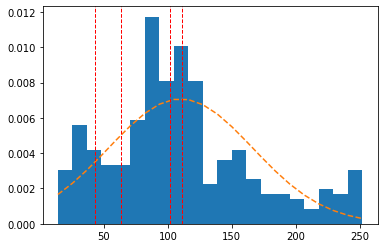

상호개수


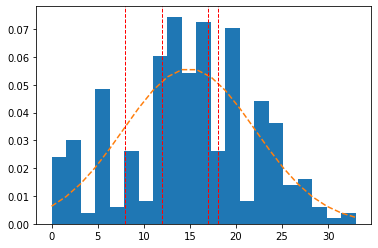

교통사고건수


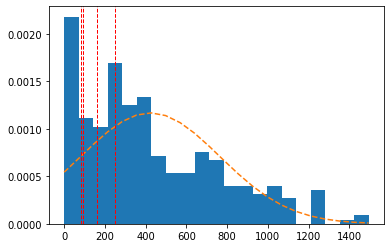

보호구역개수


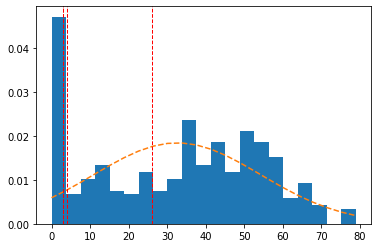

화재발생건수


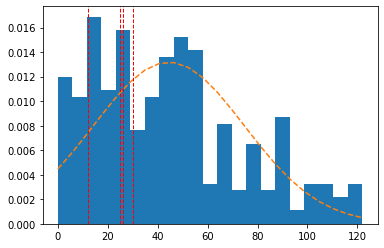

In [88]:
histo_norm_vline(Gwangju_weight_df, Gwangju_hydro_weight_df,'Gwangju')

버정거리총합


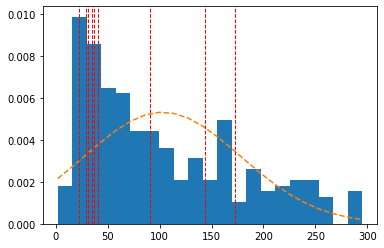

상호개수


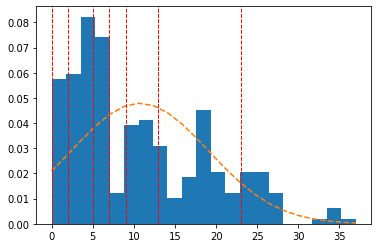

교통사고건수


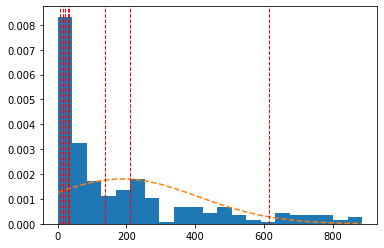

보호구역개수


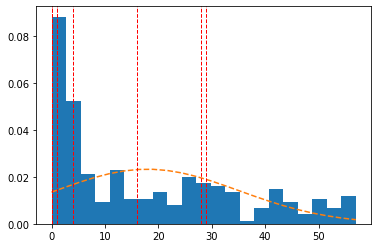

화재발생건수


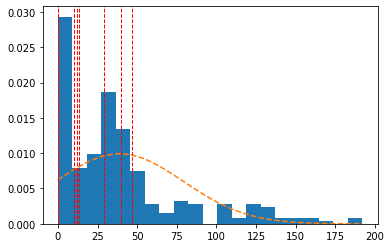

In [121]:
histo_norm_vline(Ulsan_weight_df, Ulsan_hydro_weight_df,'Ulsan')

버정거리총합


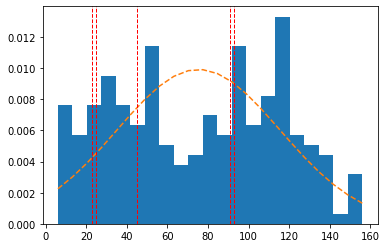

상호개수


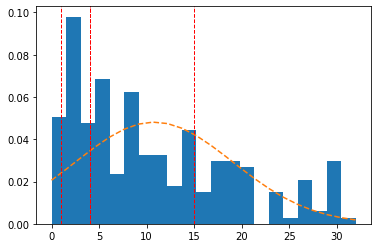

교통사고건수


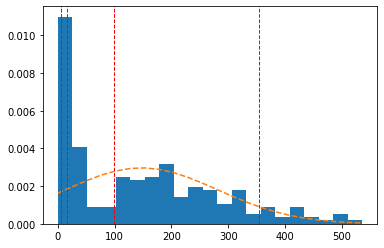

보호구역개수


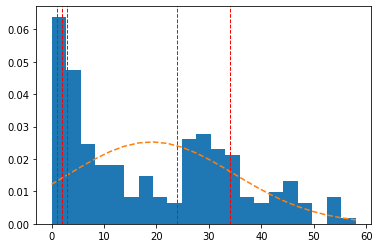

화재발생건수


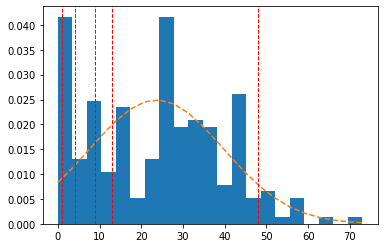

In [115]:
histo_norm_vline(Changwon_weight_df, Changwon_hydro_weight_df,'Changwon')

## 스케일링

In [112]:
from sklearn.preprocessing import MinMaxScaler
minMaxScaler = MinMaxScaler()
print(minMaxScaler.fit(weight_df.iloc[:,[1,2,3,4,5]]))
weight_df_stdScaled = minMaxScaler.transform(weight_df.iloc[:,[1,2,3,4,5]])
weight_df_stdScaled=pd.DataFrame(weight_df_stdScaled, columns=["버정거리총합","상호개수","교통사고건수","보호구역개수","화재발생건수"])
weight_df_stdScaled["주유소명"]=weight_df["주유소명"][:]
weight_df_stdScaled

MinMaxScaler()


,버정거리총합,상호개수,교통사고건수,보호구역개수,화재발생건수,주유소명
0,0.006667,0.09375,0.000000,0.000000,0.013699,SK행복충전 불모가스충전소
1,0.480000,0.31250,0.320896,0.431034,0.356164,동부2
2,0.413333,0.56250,0.236940,0.189655,0.232877,(유)공단가스산업
3,0.533333,0.43750,0.330224,0.293103,0.410959,광신직영(두대충전소)
4,0.560000,0.46875,0.378731,0.293103,0.589041,SK행복충전 유남충전소(주)배성에너지
...,...,...,...,...,...,...
216,0.173333,0.12500,0.037313,0.068966,0.219178,판도라주유소
217,0.280000,0.15625,0.279851,0.051724,0.082192,진웅
218,0.393333,0.31250,0.061567,0.086207,0.410959,광신직영(호원셀프)
219,0.973333,0.93750,0.574627,0.775862,0.698630,야구장주유소


In [20]:
weight_df_stdScaled.to_csv(city_list[i]+" 스케일링완료.csv")

# ########## 여기까지1 - 스케일링 완, 가중치 미완(lr용) ############

## 가중치 매핑 함수
새로운 데이터 프레임 만들어서 '상호'와 가중치1,2,3,4,5 넣고 총합 마지막에 하고 sort해서 [:20] 출력

### 가산
주유소_count_list=반경이내_개수_리스트(2, gas_station_df, gas_station_df,'상호')

distance_list=거리총합리스트(gas_station_df, bus_station_df, '상호')

교통사고_count_list=반경이내_개수_리스트(2, gas_station_df, accident_df,'상호')
### 감점
유치원_count_list=반경이내_개수_리스트(2, gas_station_df, kinder_df, '상호')

유초중고_count_list=반경이내_개수_리스트(2, gas_station_df, school_df, '상호')

화재_count_list=반경이내_개수_리스트(2, gas_station_df, fire_incident_df, '상호')

In [21]:
# **주유소 순서 헤치지 말 것**
#columns=['버정거리총합', '상호개수', '교통사고건수','보호구역개수','화재발생건수',주유소명'])
def 가중치추가(df, ratio_list):
    for i in range(0,len(df.loc[0])-2):
        df['총 가중치']+=df.iloc[:,i]*ratio_list[i]# weight_df는 주유소명부터, ratio_list는 버정거리총합부터 시작하므로
    


In [22]:
weight_df_stdScaled["총 가중치"]=0 # 혹시 모를 사고에 대비
ratio_list=[0.001,0.1,0.1,-0.1,-0.1] # 뒤에 두개 음수 필수
가중치추가(weight_df_stdScaled, ratio_list)
weight_df_stdScaled.head(5)

,버정거리총합,상호개수,교통사고건수,보호구역개수,화재발생건수,주유소명,총 가중치
0,0.006667,0.09375,0.000000,0.000000,0.013699,SK행복충전 불모가스충전소,0.008012
1,0.480000,0.31250,0.320896,0.431034,0.356164,동부2,-0.014900
2,0.413333,0.56250,0.236940,0.189655,0.232877,(유)공단가스산업,0.038104
3,0.533333,0.43750,0.330224,0.293103,0.410959,광신직영(두대충전소),0.006899
4,0.560000,0.46875,0.378731,0.293103,0.589041,SK행복충전 유남충전소(주)배성에너지,-0.002906


In [48]:
weight_df_stdScaled.sort_values(by=["총 가중치", "주유소명"], ascending=[False, False], inplace=True) 
weight_df_stdScaled = weight_df_stdScaled.reset_index(drop=True)
weight_df_stdScaled

,버정거리총합,상호개수,교통사고건수,보호구역개수,화재발생건수,주유소명,총 가중치
0,0.733333,0.71875,0.809701,0.431034,0.369863,CJ대한통운㈜ 오동동셀프주유소,0.073489
1,0.893333,0.90625,1.000000,0.689655,0.506849,금강주유소,0.071868
2,0.700000,0.65625,0.800373,0.431034,0.369863,지에스칼텍스㈜ 마산월드주유소,0.066273
3,0.853333,0.87500,0.930970,0.758621,0.506849,성운주유소,0.054903
4,0.880000,0.90625,0.936567,0.706897,0.602740,합포주유소,0.054198
...,...,...,...,...,...,...,...
216,0.793333,0.18750,0.598881,0.844828,0.767123,신월주유소,-0.081764
217,0.666667,0.15625,0.335821,0.793103,0.534247,지에스칼텍스㈜ 감동주유소,-0.082861
218,0.706667,0.15625,0.333955,0.810345,0.534247,남창원농협주유소,-0.084732
219,0.733333,0.21875,0.647388,0.931034,0.890411,동부3,-0.094797


In [24]:
#weight_df_stdScaled_sorted.to_csv(city_list[2]+" 가중치.csv")

# ########## 여기까지2 - 스케일링, 가중치 모두 완 (f1용)

## 정확도 나타내기
- lr
- f1

In [49]:
# 실제 data
guess_df=pd.read_csv(city_list[i]+" data 경도 위도 매핑/"+city_list[i]+"_충전소.csv")
guess_df

IndexError: list index out of range

In [50]:
# 실제를 전체 주유소에 대입
labels_df=pd.DataFrame([[0]*2]*len(weight_df_stdScaled), columns=['주유소명','label'])
labels_df['주유소명']=weight_df_stdScaled['주유소명']
for i in range(len(guess_df)):
    if labels_df['주유소명'][i]==guess_df['충전소'][i]:
        labels_df['label'][i]+=1
labels_df

,주유소명,label
0,CJ대한통운㈜ 오동동셀프주유소,0
1,금강주유소,0
2,지에스칼텍스㈜ 마산월드주유소,0
3,성운주유소,0
4,합포주유소,0
...,...,...
216,신월주유소,0
217,지에스칼텍스㈜ 감동주유소,0
218,남창원농협주유소,0
219,동부3,0


In [51]:
weight_df_stdScaled_sorted

In [52]:
# weight_df_sorted 상위 10개 label에 1 넣음
eval_df=pd.DataFrame([[0]*2]*len(weight_df_stdScaled), columns=['주유소명','label'])
weight_df_stdScaled.sort_values(by=["총 가중치", "주유소명"], ascending=[False, False], inplace=True) 
eval_df['주유소명']=weight_df_stdScaled['주유소명'][:]
eval_df['label'][:len(guess_df)]=1#일단 그냥 추측 개수 같게 했다,,
eval_df

<ipython-input-52-fa74eba53aec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['label'][:len(guess_df)]=1#일단 그냥 추측 개수 같게 했다,,
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,주유소명,label
0,CJ대한통운㈜ 오동동셀프주유소,1
1,금강주유소,1
2,지에스칼텍스㈜ 마산월드주유소,1
3,성운주유소,1
4,합포주유소,1
...,...,...
216,신월주유소,0
217,지에스칼텍스㈜ 감동주유소,0
218,남창원농협주유소,0
219,동부3,0


In [53]:
# 전체 충전소 개수 중 guess의 개수 안에 있는 충전소 개수
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
eval_df['label']=0
# eval_df.columns=['주유소명','label']
for i in range(len(guess_df)):
    if guess_df['충전소'][i]==eval_df['주유소명'][i]:
        eval_df['label'][i]+=1

eval_df.sort_values(by=["주유소명"], ascending=[False]) 
guess_df.sort_values(by=["충전소"], ascending=[False]) 
# 원래 친구
labels=labels_df['label']
# 추정한 친구
guesses=eval_df['label']
guesses

0      0
1      0
2      0
3      0
4      0
      ..
216    0
217    0
218    0
219    0
220    0
Name: label, Length: 221, dtype: int64

In [54]:
print(accuracy_score(labels, guesses))
print(recall_score(labels, guesses))
print(precision_score(labels, guesses))
print(f1_score(labels, guesses))

1.0
0.0
0.0
0.0


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


## 동 매핑

동이랑 통행속도 매핑

gas_station_df['주소']-도로 이름 나오니까 그냥 사용

travel_speed['도로명'], ['속도']

In [30]:
# 그냥 대충 만든 거
travel_speed=pd.DataFrame([['혁신로', 20],['기지로', 30],['쑥고개로', 10],['권삼득로', 33]], columns=['도로명','속도'])
travel_speed

,도로명,속도
0,혁신로,20
1,기지로,30
2,쑥고개로,10
3,권삼득로,33


In [31]:
# 가중치 데이터 프레임
weight_df=pd.DataFrame([[0]*5]*len(gas_station_df), columns=['주유소_이름', '주소','통행속도_w', 'a', 'b'])
weight_df['주유소_이름']=gas_station_df['상호'][:]
weight_df['주소']=gas_station_df['주소'][:]
weight_df

,주유소_이름,주소,통행속도_w,a,b
0,SK행복충전 불모가스충전소,경남 창원시 성산구 창원대로 1310 (불모산동),0,0,0
1,동부2,경남 창원시 진해구 진해대로 732 (석동),0,0,0
2,(유)공단가스산업,경남 창원시 마산회원구 봉암공단8길 2,0,0,0
3,광신직영(두대충전소),경남 창원시 의창구 남면로 3 (대원동),0,0,0
4,SK행복충전 유남충전소(주)배성에너지,경남 창원시 의창구 창원대로 314 (팔용동),0,0,0
...,...,...,...,...,...
216,판도라주유소,경남 창원시 마산합포구 진동면 삼진의거대로 753,0,0,0
217,진웅,경남 창원시 진해구 웅천로 156 (북부동),0,0,0
218,광신직영(호원셀프),경남 창원시 마산회원구 내서읍 호원로 141,0,0,0
219,야구장주유소,경남 창원시 마산합포구 용마로 62,0,0,0


In [32]:
for i in range(len(travel_speed)):
    for j in range(len(gas_station_df)):
        if travel_speed.loc[i]['도로명'] in gas_station_df.loc[j]['주소']:
            # gas_station_df.loc[j]['상호']
            # 하는 중
            # weight_df.iloc['주유소_이름']['통행속도_w']+=1
weight_df

IndentationError: expected an indented block (<ipython-input-32-3dfeeb1f015a>, line 7)

In [3]:
score_df=pd.read_csv("점수계산끝.csv")
score_df

,Unnamed: 0,주유소명,버정거리총합,상호개수,교통사고건수,보호구역개수,화재발생건수,총 가중치,주소,위도,경도
0,0,직영충전소,2,1,1,5,1,1.604,전북 전주시 덕진구 혁신로 360번지,35.864542,127.069401
1,1,(유)삼영에너지,5,5,5,5,5,5.000,전북 전주시 완산구 쑥고개로 11 (용복동),35.790810,127.068859
2,2,(유)푸른기업충전소,1,4,1,1,1,1.105,전북 전주시 완산구 모악로 4483 (석구동),35.786460,127.128841
3,3,㈜진성에너지 색장충전소,5,5,4,1,5,4.204,전북 전주시 완산구 춘향로 4900 (색장동),35.785086,127.195279
4,4,전주유성LPG충전소,5,5,4,5,5,4.740,전북 전주시 완산구 춘향로 4981,35.786834,127.193891
...,...,...,...,...,...,...,...,...,...,...,...
193,193,(주)안국에너지 호반주유소,1,4,1,1,1,1.105,전북 전주시 덕진구 기린대로 600 (덕진동2가),35.846412,127.110653
194,194,동아주유소,1,1,1,1,1,1.000,전북 전주시 완산구 모악로 4741 (평화동2가),35.792515,127.131511
195,195,중앙주유소,4,5,1,5,3,2.886,전북 전주시 덕진구 전미로 148 (전미동2가),35.882328,127.110466
196,196,덕산주유소,5,5,4,1,5,4.204,전북 전주시 완산구 춘향로 4923 (색장동),35.782581,127.197516


In [7]:
score_df.sort_values(by=["총 가중치"], ascending=[False], inplace=True) 
score_df[:4]

,Unnamed: 0,주유소명,버정거리총합,상호개수,교통사고건수,보호구역개수,화재발생건수,총 가중치,주소,위도,경도
1,1,(유)삼영에너지,5,5,5,5,5,5.0,전북 전주시 완산구 쑥고개로 11 (용복동),35.790810,127.068859
159,159,동양주유소,5,5,5,5,5,5.0,전북 전주시 덕진구 전미로 231 (전미동2가),35.888497,127.105103
179,179,석구주유소,5,5,5,5,5,5.0,전북 전주시 완산구 구이로 1828 (석구동),35.761439,127.125947
94,94,서린2주유소,5,5,5,5,5,5.0,전북 전주시 완산구 선비로 1444 (용복동),35.790174,127.068150
